In [2]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
import sys
from sklearn.base import BaseEstimator
from sklearn.metrics import classification_report

sys.path.append(r"E:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\libs")

from libs.utils import *

DATASET_PATH = r"E:\Learn Machine Learning\Project\Opinion Classifier\res\dataset\tf-idf-remv-stopwords.csv"

# 1. Load và xử lý dữ liệu:

In [3]:
data = read_dataset(
    dataset_path= DATASET_PATH,
    file_type="csv",
    header=0
)

02:08:42 root INFO: Đang đọc dữ liệu từ file E:\Learn Machine Learning\Project\Opinion Classifier\res\dataset\tf-idf-remv-stopwords.csv ...
		at Line 330 [read_dataset() in utils.py, utils]
02:08:49 root INFO: Đọc thành công! 
		at Line 338 [read_dataset() in utils.py, utils]


In [4]:
data.head()

,Unnamed: 0,thạc,666,tham_khảo,danh,gấp_bội,nhàg,ứng,gài,mặc_dù,...,nghìn,center,trượt_tín,bậc,tự_động,cmt,sứ_mệnh,live,địa_phương,label
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral


In [5]:
data = data.drop(columns=data.columns.values[0], axis=1)
data.head()

,thạc,666,tham_khảo,danh,gấp_bội,nhàg,ứng,gài,mặc_dù,rộng_rãi,...,nghìn,center,trượt_tín,bậc,tự_động,cmt,sứ_mệnh,live,địa_phương,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral


In [6]:
labels : list[str] = data["label"].unique().tolist()
labels.sort(reverse=True)
labels

['Positive', 'Neutral', 'Negative']

In [7]:
n_samples_classes = data["label"].value_counts().to_dict()
n_samples_classes

{'Positive': 1085, 'Neutral': 842, 'Negative': 569}

In [8]:
n_samples : int = len(data)
class_weight : dict[str, float] = {k : n_samples / (len(labels) * n_samples_classes.get(k)) for k in n_samples_classes}
class_weight

{'Positive': 0.7668202764976959,
 'Neutral': 0.9881235154394299,
 'Negative': 1.4622144112478033}

Thực hiện chia dữ liệu thành hai tập training set và testing set. **Chú ý**: tập dữ liệu này chưa được chia cân bằng. Phần chia cân bằng sẽ thực hiện ở mục 4.

In [9]:
training_set, testing_set = train_test_split(data, test_size=0.2, random_state=42, shuffle=True, stratify=data["label"].values)
training_set[:10]

,thạc,666,tham_khảo,danh,gấp_bội,nhàg,ứng,gài,mặc_dù,rộng_rãi,...,nghìn,center,trượt_tín,bậc,tự_động,cmt,sứ_mệnh,live,địa_phương,label
604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Negative
2352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Neutral
255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.436551,0.0,0.0,Positive
1972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Positive
2034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Neutral
1925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Positive
447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Positive
738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Positive
155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Positive
274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Positive


In [10]:
def draw_labels_rate_pie(y : pd.Series, title : str="Tỉ lệ nhãn tập dữ liệu", save_fig : bool = False):
    precent_rate = lambda sub , total : (sub / total) * 100
    labels = list(y.unique())
    labels.sort()
    labels_rate = [precent_rate(len(y[y == x]), len(y)) for x in labels]
    fig_labels_rate, ax = plt.subplots()
    ax.pie(labels_rate, labels=[str(len(y[y == x])) for x in labels], autopct='%1.2f%%', shadow=False)
    plt.title(title)
    plt.legend(loc="lower right", labels=labels)
    if save_fig:
        save_fig(IMAGES_PATH, "Labels Rate")    

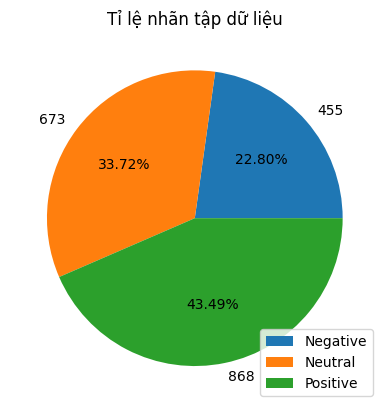

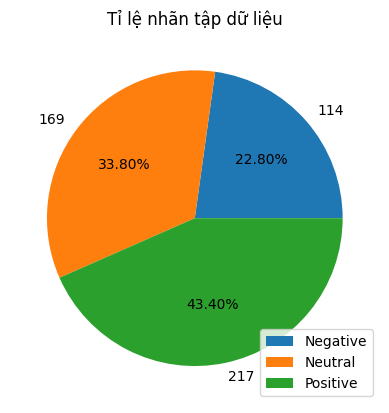

In [11]:
draw_labels_rate_pie(training_set["label"])

draw_labels_rate_pie(testing_set["label"])

In [12]:
X_train : pd.DataFrame = training_set.drop(columns="label", axis=1)
y_train : pd.Series = training_set["label"].copy()
X_testing : pd.DataFrame = testing_set.drop(columns="label", axis=1)
y_testing : pd.Series = testing_set["label"].copy()

In [13]:
y_train_encode = y_train.apply(lambda x : {label : i for i, label in enumerate(labels)}.get(x))
y_train_encode.head()

604     2
2352    1
255     0
1972    0
2034    1
Name: label, dtype: int64

In [14]:
y_testing_encode = y_testing.apply(lambda x : {label : i for i, label in enumerate(labels)}.get(x))
y_testing_encode.head()

1780    0
711     0
322     2
149     1
902     0
Name: label, dtype: int64

In [15]:
y_encode_label = {label : i for i, label in enumerate(labels)}

class_weight = {y_encode_label.get(k) : class_weight.get(k) for k in class_weight}
class_weight

{0: 0.7668202764976959, 1: 0.9881235154394299, 2: 1.4622144112478033}

# 2. Huấn luyện mô hình SVM:

## 2.1. Huấn luyện mô hình thử với LinearSVC:

Các siêu tham số gồm có:
* **loss**: `hinge` và `squared_hinge`. Lựa chọn hàm mất mát dạng `hinge` hoặc `squared_hinge`

Hàm mất mát `hinge` có dạng: $ J_n(\bold{w}, b) = \max{(0, 1 - y_n z_n)} $, với $ z_n $ là điểm số của $ \bold{x_n} $ ứng với cặp hệ số $ (\bold{w_n}, b) $, $ y_n $ là đầu ra mong muốn

Hàm mất mát `squared_hinge` có dạng: $ J_n(\bold{w}, b) = (\max{(0, 1 - y_n z_n)})^2 $

Tham khảo tại: https://machinelearningcoban.com/2017/04/13/softmarginsmv/, https://en.wikipedia.org/wiki/

* **penalty**: `l1` và `l2`. Lựa chọn dạng chuẩn hóa.

Chuẩn hóa dạng `l1` không kết hợp được khi loss=`hinge`

Chuẩn hóa dạng `l1` chỉ kết hợp được với `squared_hinge` khi tham số dual=`False`

* **dual**: siêu tham số quyết định việc tối ưu hóa thực hiện theo bài toán dual hoặc primal.

* **tol**: Dung sai dừng vòng lặp. Mặc định tol=`1e-4`

* **C**: Siêu tham số chuẩn hóa. Độ lớn của C tỉ lệ nghịch với mức độ chuẩn hóa.

* **class_weight**: Siêu tham số biểu thị trọng số của lớp.

* **max_iter**: Siêu tham số chỉ định số vòng lặp tối đa mà mô hình chạy trong quá trình tìm kiếm bộ tham số tối ưu.

GridSearch tìm bộ tham số tối ưu cho mô hình LinearSVC không scale dữ liệu

In [17]:
logging.info("Start grid search:")
svc_grid_params = [
    {
        'C' : np.logspace(-3, 3, num=30),
        'fit_intercept' : [True, False],
        'intercept_scaling' : np.logspace(1, 3, num=10),
    }
]

svc_grid_search = GridSearchCV(
    estimator=LinearSVC(loss="squared_hinge", multi_class="ovr", class_weight=class_weight, verbose=4, random_state=42, max_iter=20000, penalty='l1', dual=False),
    param_grid=svc_grid_params,
    scoring='f1_weighted',
    n_jobs=-1,
    cv=5,
    verbose=4,
    return_train_score=True,
)

svc_grid_search.fit(X_train, y_train_encode)

logging.info(f"Best params: {svc_grid_search.best_params_}")
logging.info(f"Best scores: {svc_grid_search.best_score_}")

save_model("remove_stopword_linear_svc.pkl")

y_pred = svc_grid_search.best_estimator_.predict(X_testing)

print(classification_report(y_testing_encode, y_pred))

02:15:24 root INFO: Start grid search:
		at Line 1 [<module>() in 3084688443.py, 3084688443]


Fitting 5 folds for each of 600 candidates, totalling 3000 fits


03:50:22 root INFO: Best params: {'C': 0.02807216203941177, 'fit_intercept': False, 'intercept_scaling': 10.0}
		at Line 22 [<module>() in 3084688443.py, 3084688443]
03:50:22 root INFO: Best scores: 0.6878878058717635
		at Line 23 [<module>() in 3084688443.py, 3084688443]


[LibLinear]

TypeError: save_model() missing 1 required positional argument: 'estimator'

In [19]:

save_model("remove_stopword_linear_svc.pkl", svc_grid_search.best_estimator_)

y_pred = svc_grid_search.best_estimator_.predict(X_testing)

print(classification_report(y_testing_encode, y_pred))

09:11:00 root INFO: Đang lưu lại mô hình...
		at Line 88 [save_model() in utils.py, utils]
09:11:00 root INFO: Lưu thành công!
		at Line 92 [save_model() in utils.py, utils]


              precision    recall  f1-score   support

           0       0.80      0.74      0.77       217
           1       0.66      0.67      0.66       169
           2       0.54      0.59      0.56       114

    accuracy                           0.68       500
   macro avg       0.66      0.67      0.67       500
weighted avg       0.69      0.68      0.69       500



In [ ]:
save_model(estimator=svc_grid_search.best_estimator_, file_name="linear_svc.pkl")

00:41:31 root INFO: Đang lưu lại mô hình...
		at Line 88 [save_model() in utils.py, utils]
00:41:31 root INFO: Lưu thành công!
		at Line 92 [save_model() in utils.py, utils]


## 2.2. Huấn luyện mô hình với SVC(Kernal="RBF"):

Các siêu tham số có trong SVC(Kernal="rbf") cần lưu ý:

* **C**: Siêu tham số chuẩn hóa của mô hình. C càng cao lề đường càng nhỏ và ngược lại.

* **gamma**: Siêu tham số độ xa của ảnh hưởng của các đối tượng huấn luyện. Gamma càng cao thì đường phân lớp càng bó sát và quanh co xung quanh không gian đối tượng và ngược lại, gamma càng nhỏ thì đường phân lớp càng rộng và bao một diện tích xa hơn so với không gian đối tượng huấn luyện.

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

09:16:49 root INFO: Saving figure 'RemoveStopwordSVMRBFDefault1' ...
		at Line 62 [save_fig() in utils.py, utils]
09:16:49 root INFO: Saved figure 'RemoveStopwordSVMRBFDefault1'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\RemoveStopwordSVMRBFDefault1.png
		at Line 66 [save_fig() in utils.py, utils]


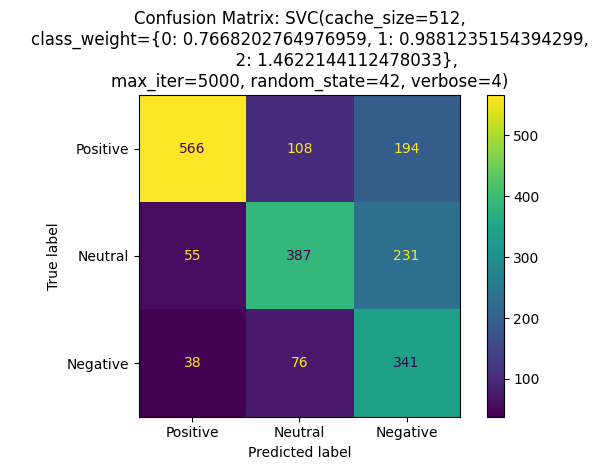

09:16:49 root INFO: 
Average: None
Precision:	[0.85887709 0.67775832 0.44516971]
Recall:		[0.65207373 0.57503715 0.74945055]
--> F1-score:	[0.74132286 0.6221865  0.55855856]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.85887709, 0.67775832, 0.44516971]),
 array([0.65207373, 0.57503715, 0.74945055]),
 array([0.74132286, 0.6221865 , 0.55855856]))

In [20]:
svc_clf = SVC(kernel="rbf", class_weight=class_weight, verbose=4, max_iter=5000, decision_function_shape="ovr", random_state=42,cache_size=512)

svc_clf.fit(X_train, y_train_encode)

measure_score(svc_clf, X_train, y_train_encode, None, labels, cv=10, fig_title="RemoveStopwordSVMRBFDefault1")

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

09:45:19 root INFO: Saving figure 'SVMRBFDefault1' ...
		at Line 62 [save_fig() in utils.py, utils]
09:45:19 root INFO: Saved figure 'SVMRBFDefault1'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\SVMRBFDefault1.png
		at Line 66 [save_fig() in utils.py, utils]


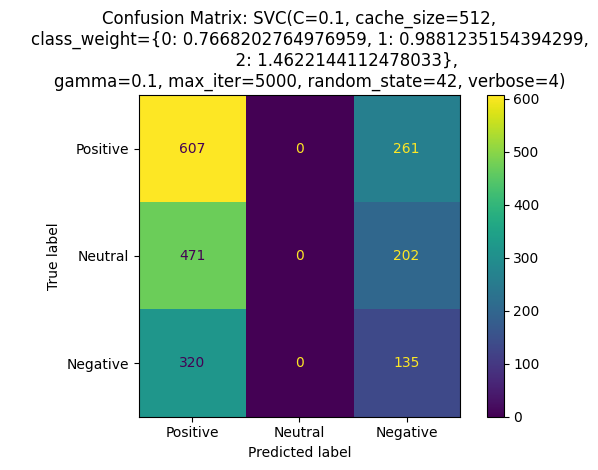

e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
09:45:20 root INFO: 
Average: None
Precision:	[0.4341917  0.         0.22575251]
Recall:		[0.69930876 0.         0.2967033 ]
--> F1-score:	[0.53574581 0.         0.25641026]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.4341917 , 0.        , 0.22575251]),
 array([0.69930876, 0.        , 0.2967033 ]),
 array([0.53574581, 0.        , 0.25641026]))

In [21]:
svc_clf = SVC(kernel="rbf", class_weight=class_weight, verbose=4, max_iter=5000, decision_function_shape="ovr", random_state=42,cache_size=512, C=0.1, gamma=1e-1)

svc_clf.fit(X_train, y_train_encode)

measure_score(svc_clf, X_train, y_train_encode, None, labels, cv=10, fig_title="SVMRBFDefault1")

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

09:48:45 root INFO: Saving figure 'RemoveStopwordSVMRBFDefault2' ...
		at Line 62 [save_fig() in utils.py, utils]
09:48:45 root INFO: Saved figure 'RemoveStopwordSVMRBFDefault2'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\RemoveStopwordSVMRBFDefault2.png
		at Line 66 [save_fig() in utils.py, utils]


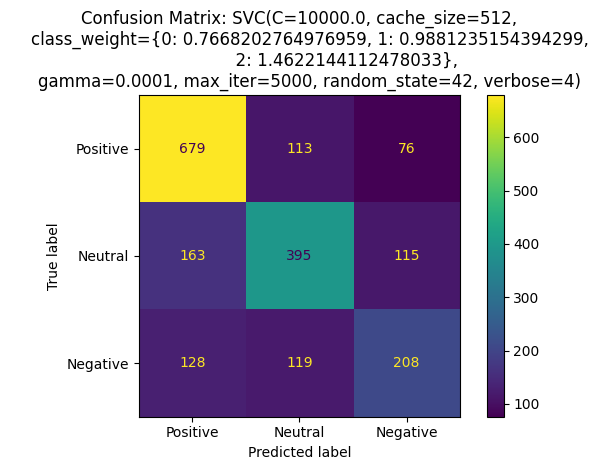

09:48:46 root INFO: 
Average: None
Precision:	[0.7        0.62998405 0.52130326]
Recall:		[0.78225806 0.58692422 0.45714286]
--> F1-score:	[0.73884657 0.60769231 0.48711944]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.7       , 0.62998405, 0.52130326]),
 array([0.78225806, 0.58692422, 0.45714286]),
 array([0.73884657, 0.60769231, 0.48711944]))

In [22]:
svc_clf = SVC(kernel="rbf", class_weight=class_weight, verbose=4, max_iter=5000, decision_function_shape="ovr", random_state=42,cache_size=512, C=1e+4, gamma=1e-4)

svc_clf.fit(X_train, y_train_encode)

measure_score(svc_clf, X_train, y_train_encode, None, labels, cv=10, fig_title="RemoveStopwordSVMRBFDefault2")

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

09:53:48 root INFO: Saving figure 'RemoveStopwordSVMRBFDefault3' ...
		at Line 62 [save_fig() in utils.py, utils]
09:53:48 root INFO: Saved figure 'RemoveStopwordSVMRBFDefault3'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\RemoveStopwordSVMRBFDefault3.png
		at Line 66 [save_fig() in utils.py, utils]


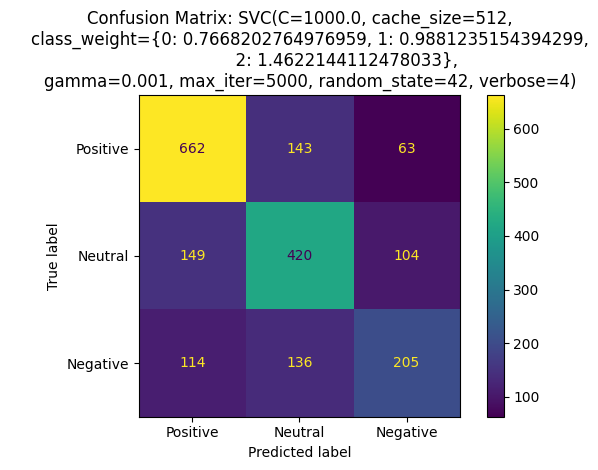

09:53:49 root INFO: 
Average: None
Precision:	[0.71567568 0.60085837 0.55107527]
Recall:		[0.76267281 0.62407132 0.45054945]
--> F1-score:	[0.73842722 0.6122449  0.49576784]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.71567568, 0.60085837, 0.55107527]),
 array([0.76267281, 0.62407132, 0.45054945]),
 array([0.73842722, 0.6122449 , 0.49576784]))

In [23]:
svc_clf = SVC(kernel="rbf", class_weight=class_weight, verbose=4, max_iter=5000, decision_function_shape="ovr", random_state=42,cache_size=512, C=1e+3, gamma=1e-3)

svc_clf.fit(X_train, y_train_encode)

measure_score(svc_clf, X_train, y_train_encode, None, labels, cv=10, fig_title="RemoveStopwordSVMRBFDefault3")

GridSearch cho SVM(kernal="rbf")

In [ ]:
svc_grid_params = [
    {
        'C' : np.logspace(-3, 3, num=50),
        'gamma' : np.logspace(-3, 3, num=20)
    }
]

svc_grid_search = GridSearchCV(
    estimator=SVC(kernel="rbf", class_weight=class_weight, verbose=4, max_iter=5000, decision_function_shape="ovr", random_state=42,cache_size=512),
    param_grid=svc_grid_params,
    scoring='f1_weighted',
    n_jobs=-1,
    cv=5,
    verbose=4,
    return_train_score=True,
)

svc_grid_search.fit(X_train, y_train_encode)

measure_score(svc_grid_search.best_estimator_, X_train, y_train_encode, None, labels, cv=10, save_figure=True, fig_title="SVMRBFGridsearchBestParams")

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


Sử dụng sigmoid kernel:

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

12:08:17 root INFO: Saving figure 'SVMSigmoidDefault1' ...
		at Line 62 [save_fig() in utils.py, utils]
12:08:17 root INFO: Saved figure 'SVMSigmoidDefault1'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\SVMSigmoidDefault1.png
		at Line 66 [save_fig() in utils.py, utils]


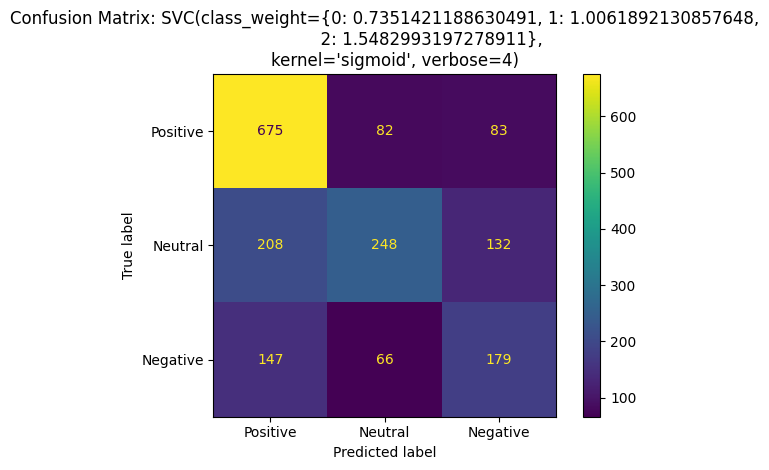

12:08:18 root INFO: 
Average: None
Precision:	[0.65533981 0.62626263 0.45431472]
Recall:		[0.80357143 0.42176871 0.45663265]
--> F1-score:	[0.72192513 0.50406504 0.45547074]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.65533981, 0.62626263, 0.45431472]),
 array([0.80357143, 0.42176871, 0.45663265]),
 array([0.72192513, 0.50406504, 0.45547074]))

In [ ]:
svc_clf = SVC(kernel="sigmoid", class_weight=class_weight, verbose=4, max_iter=-1)
svc_clf.fit(X_train, y_train_encode)

measure_score(svc_clf, X_train, y_train_encode, None, labels, cv=10, save_figure=True, fig_title="SVMSigmoidDefault1")

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

12:23:25 root INFO: Saving figure 'SVMSigmoidDefault2' ...
		at Line 62 [save_fig() in utils.py, utils]
12:23:25 root INFO: Saved figure 'SVMSigmoidDefault2'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\SVMSigmoidDefault2.png
		at Line 66 [save_fig() in utils.py, utils]


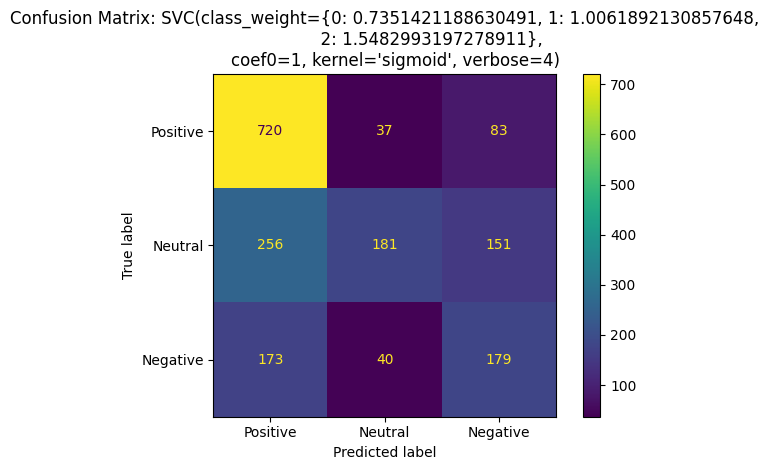

12:23:25 root INFO: 
Average: None
Precision:	[0.62663185 0.70155039 0.43341404]
Recall:		[0.85714286 0.30782313 0.45663265]
--> F1-score:	[0.7239819  0.42789598 0.4447205 ]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.62663185, 0.70155039, 0.43341404]),
 array([0.85714286, 0.30782313, 0.45663265]),
 array([0.7239819 , 0.42789598, 0.4447205 ]))

In [ ]:
svc_clf = SVC(kernel="sigmoid", class_weight=class_weight, verbose=4, max_iter=-1, coef0=1)
svc_clf.fit(X_train, y_train_encode)

measure_score(svc_clf, X_train, y_train_encode, None, labels, cv=10, save_figure=True, fig_title="SVMSigmoidDefault2")

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

12:32:38 root INFO: Saving figure 'SVMSigmoidDefault2' ...
		at Line 62 [save_fig() in utils.py, utils]
12:32:38 root INFO: Saved figure 'SVMSigmoidDefault2'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\SVMSigmoidDefault2.png
		at Line 66 [save_fig() in utils.py, utils]


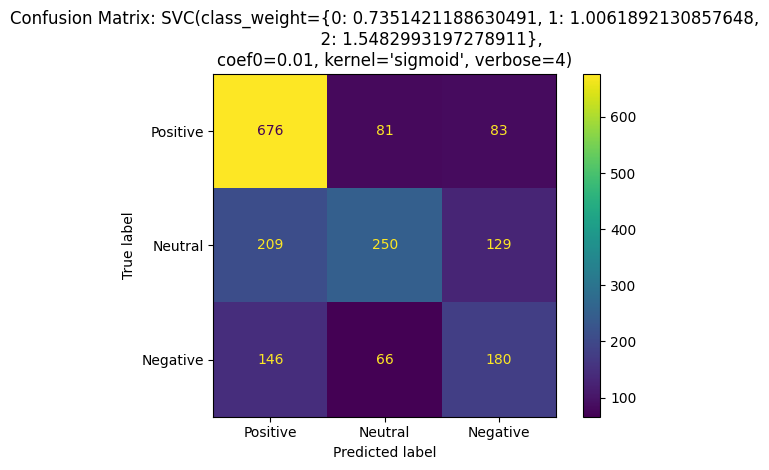

12:32:39 root INFO: 
Average: None
Precision:	[0.6556741  0.62972292 0.45918367]
Recall:		[0.8047619  0.42517007 0.45918367]
--> F1-score:	[0.72260823 0.50761421 0.45918367]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.6556741 , 0.62972292, 0.45918367]),
 array([0.8047619 , 0.42517007, 0.45918367]),
 array([0.72260823, 0.50761421, 0.45918367]))

In [ ]:
svc_clf = SVC(kernel="sigmoid", class_weight=class_weight, verbose=4, max_iter=-1, coef0=1e-2)
svc_clf.fit(X_train, y_train_encode)

measure_score(svc_clf, X_train, y_train_encode, None, labels, cv=10, save_figure=True, fig_title="SVMSigmoidDefault2")

# 3. Huấn luyện mô hình SVC với đầu vào dữ liệu có thu gọn (Scale):

**Mục tiêu**: Kiểm tra độ chính xác của mô hình khi dữ liệu được thu gọn. SVM rất nhạy cảm với dữ liệu, do đó nếu dữ liệu được thu gọn có thể giúp mở rộng đường phân lớp, phân lớp chính xác hơn.

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

10:47:54 root INFO: Saving figure 'LinearSVCScaled1' ...
		at Line 62 [save_fig() in utils.py, utils]
10:47:55 root INFO: Saved figure 'LinearSVCScaled1'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\LinearSVCScaled1.png
		at Line 66 [save_fig() in utils.py, utils]


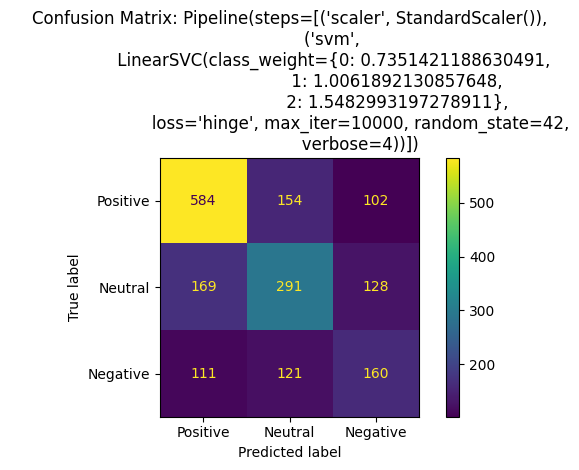

10:47:55 root INFO: 
Average: None
Precision:	[0.67592593 0.51413428 0.41025641]
Recall:		[0.6952381  0.49489796 0.40816327]
--> F1-score:	[0.68544601 0.50433276 0.40920716]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.67592593, 0.51413428, 0.41025641]),
 array([0.6952381 , 0.49489796, 0.40816327]),
 array([0.68544601, 0.50433276, 0.40920716]))

In [ ]:
svc_clf_pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("svm", LinearSVC(loss="hinge", multi_class="ovr", fit_intercept=True, class_weight=class_weight, verbose=4, random_state=42, max_iter=10000))
    ]
)

svc_clf_pipeline.fit(X_train, y_train_encode)

measure_score(svc_clf_pipeline, X_train, y_train_encode, None, labels, cv=10, fig_title="LinearSVCScaled1")

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

14:01:17 root INFO: Saving figure 'SVCRBFScaled' ...
		at Line 62 [save_fig() in utils.py, utils]
14:01:17 root INFO: Saved figure 'SVCRBFScaled'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\SVCRBFScaled.png
		at Line 66 [save_fig() in utils.py, utils]


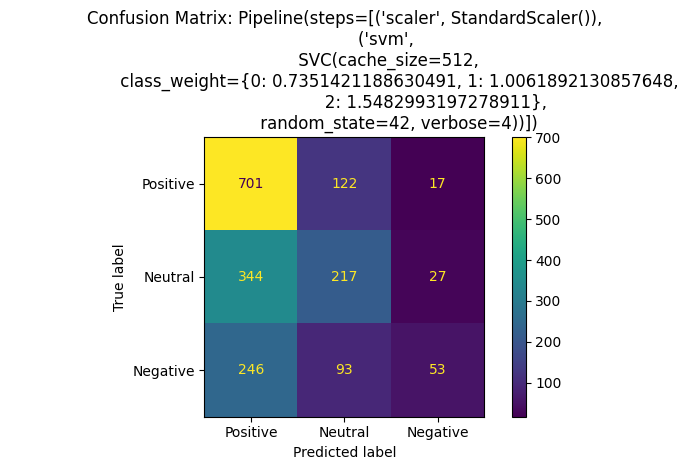

14:01:17 root INFO: 
Average: None
Precision:	[0.54298993 0.50231481 0.54639175]
Recall:		[0.83452381 0.36904762 0.13520408]
--> F1-score:	[0.65790709 0.4254902  0.21676892]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.54298993, 0.50231481, 0.54639175]),
 array([0.83452381, 0.36904762, 0.13520408]),
 array([0.65790709, 0.4254902 , 0.21676892]))

In [ ]:
svc_clf_pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="rbf", class_weight=class_weight, verbose=4, max_iter=-1, decision_function_shape="ovr", random_state=42,cache_size=512))
    ]
)

svc_clf_pipeline.fit(X_train, y_train_encode)

measure_score(svc_clf_pipeline, X_train, y_train_encode, None, labels, cv=10, fig_title="SVCRBFScaled")

# 4. Thử nghiệm với Oversampling:

Phương pháp này sẽ duplicate các đối tượng ở hai lớp thiểu số là Neutral và Negative sao cho số lượng đối tượng của hai lớp này cân bằng với lớp Positive. Tuy nhiên, ta chỉ duplicate đối với các đối tượng ở training set, còn testing set sẽ được giữ nguyên. Chia tập dữ liệu thành tập X_train, X_test, y_train, y_test với train_test_split(stratify=y) 

In [ ]:
X : pd.DataFrame = data.drop(columns="label", axis=1).copy()
y : pd.Series = data["label"]

In [ ]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [ ]:
def draw_labels_rate_pie(y : pd.Series, title : str="Tỉ lệ nhãn tập dữ liệu", save_fig : bool = False):
    precent_rate = lambda sub , total : (sub / total) * 100
    labels = list(y.unique())
    labels.sort()
    labels_rate = [precent_rate(len(y[y == x]), len(y)) for x in labels]
    fig_labels_rate, ax = plt.subplots()
    ax.pie(labels_rate, labels=[str(len(y[y == x])) for x in labels], autopct='%1.2f%%', shadow=False)
    plt.title(title)
    plt.legend(loc="lower right", labels=labels)
    if save_fig:
        save_fig(IMAGES_PATH, "Labels Rate")    

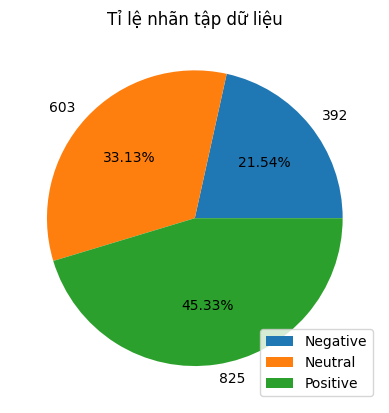

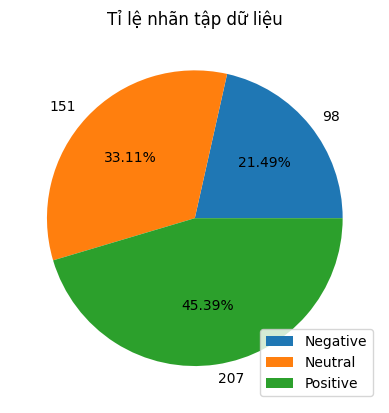

In [ ]:
draw_labels_rate_pie(train_set["label"])

draw_labels_rate_pie(test_set["label"])

Tỉ lệ tập dữ liệu đã cân bằng. Do đó, khi huấn luyện và kiểm thử sẽ cho độ khách quan

### Thực hiện oversampling trên tập huấn luyện:
Ta sẽ duplicate tập huấn luyện bằng cách lựa chọn ngẫu nhiên các đối tượng của các lớp thiểu sao cho cân bằng với lớp trội. Vẫn chú ý không động đến tập kiểm thử.

In [ ]:
train_pos : pd.DataFrame = train_set[train_set["label"] == "Positive"]
train_neg : pd.DataFrame = train_set[train_set["label"] == "Negative"]
train_neu : pd.DataFrame = train_set[train_set["label"] == "Neutral"]

train_pos["label"].value_counts(), train_neg["label"].value_counts(), train_neu["label"].value_counts()

(Positive    825
 Name: label, dtype: int64,
 Negative    392
 Name: label, dtype: int64,
 Neutral    603
 Name: label, dtype: int64)

In [ ]:
train_neg_ovs = train_neg.sample(len(train_pos), replace=True)
train_neu_ovs = train_neu.sample(len(train_pos), replace=True)

len(train_pos), len(train_neg_ovs), len(train_neu_ovs)

(825, 825, 825)

In [ ]:
train_ovs = pd.concat([train_pos, train_neu_ovs, train_neg_ovs], axis=0)
train_ovs.shape

(2475, 5775)

Phân chia tập huấn luyện thành tập X_train và y_train

In [ ]:
X_train = train_ovs.drop(columns="label", axis=1).copy()
y_train = train_ovs["label"]

Encode cho y_train:

In [ ]:
y_train_encode = y_train.apply(lambda x : {label : i for i, label in enumerate(labels)}.get(x))
y_train_encode.value_counts()

0    825
1    825
2    825
Name: label, dtype: int64

#### Huấn luyện mô hình LinearSVC trên tập oversampling:

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

14:53:11 root INFO: Saving figure 'Oversampling_LinearSVC_Default_1' ...
		at Line 62 [save_fig() in utils.py, utils]
14:53:11 root INFO: Saved figure 'Oversampling_LinearSVC_Default_1'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\Oversampling_LinearSVC_Default_1.png
		at Line 66 [save_fig() in utils.py, utils]


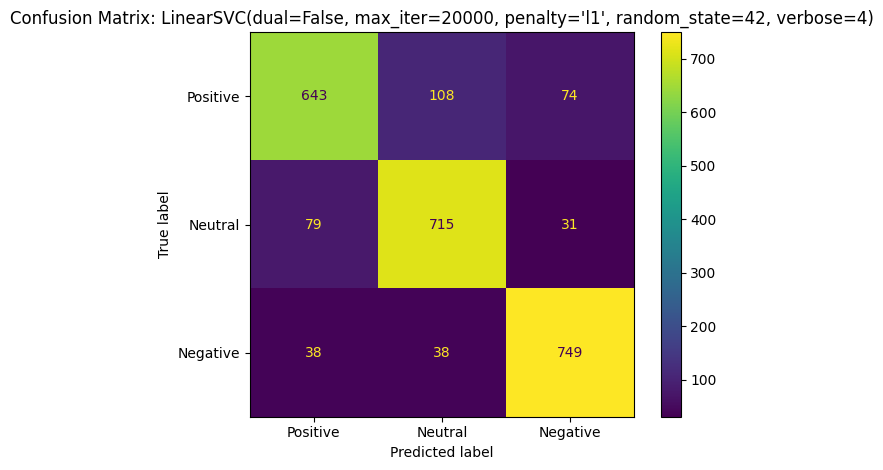

14:53:12 root INFO: 
Average: None
Precision:	[0.84605263 0.83042973 0.87704918]
Recall:		[0.77939394 0.86666667 0.90787879]
--> F1-score:	[0.81135647 0.84816133 0.89219774]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.84605263, 0.83042973, 0.87704918]),
 array([0.77939394, 0.86666667, 0.90787879]),
 array([0.81135647, 0.84816133, 0.89219774]))

In [ ]:
svc_clf = LinearSVC(loss="squared_hinge", multi_class="ovr", verbose=4, random_state=42, max_iter=20000, penalty='l1', dual=False)

svc_clf.fit(X_train, y_train_encode)

measure_score(svc_clf, X_train, y_train_encode, None, labels, 10, fig_title="Oversampling_LinearSVC_Default_1")

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

14:54:45 root INFO: Saving figure 'Oversampling_LinearSVC_Default_2' ...
		at Line 62 [save_fig() in utils.py, utils]
14:54:45 root INFO: Saved figure 'Oversampling_LinearSVC_Default_2'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\Oversampling_LinearSVC_Default_2.png
		at Line 66 [save_fig() in utils.py, utils]


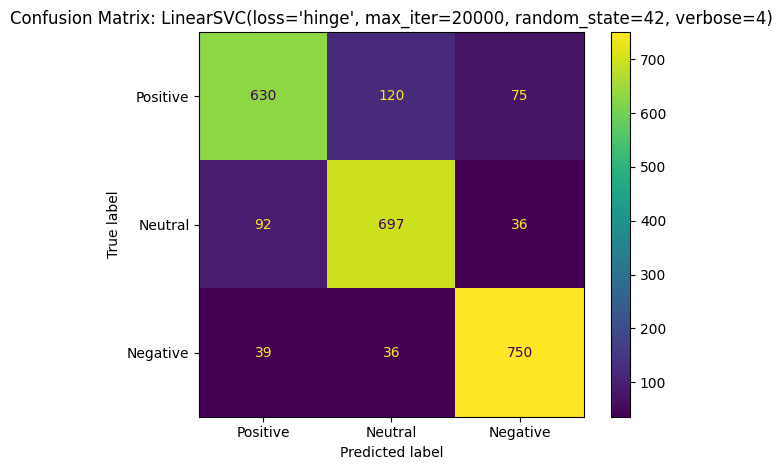

14:54:46 root INFO: 
Average: None
Precision:	[0.82785808 0.81711606 0.87108014]
Recall:		[0.76363636 0.84484848 0.90909091]
--> F1-score:	[0.79445145 0.83075089 0.88967972]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.82785808, 0.81711606, 0.87108014]),
 array([0.76363636, 0.84484848, 0.90909091]),
 array([0.79445145, 0.83075089, 0.88967972]))

In [ ]:
svc_clf = LinearSVC(loss="hinge", multi_class="ovr", verbose=4, random_state=42, max_iter=20000, penalty='l2', dual=True)

svc_clf.fit(X_train, y_train_encode)

measure_score(svc_clf, X_train, y_train_encode, None, labels, 10, fig_title="Oversampling_LinearSVC_Default_2")

[LibLinear]

e:\Python\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

e:\Python\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

e:\Python\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear][LibLinear]

e:\Python\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

e:\Python\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

e:\Python\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

e:\Python\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

e:\Python\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

e:\Python\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[LibLinear]

e:\Python\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
14:56:59 root INFO: Saving figure 'Oversampling_LinearSVC_Default_3' ...
		at Line 62 [save_fig() in utils.py, utils]
14:56:59 root INFO: Saved figure 'Oversampling_LinearSVC_Default_3'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\Oversampling_LinearSVC_Default_3.png
		at Line 66 [save_fig() in utils.py, utils]


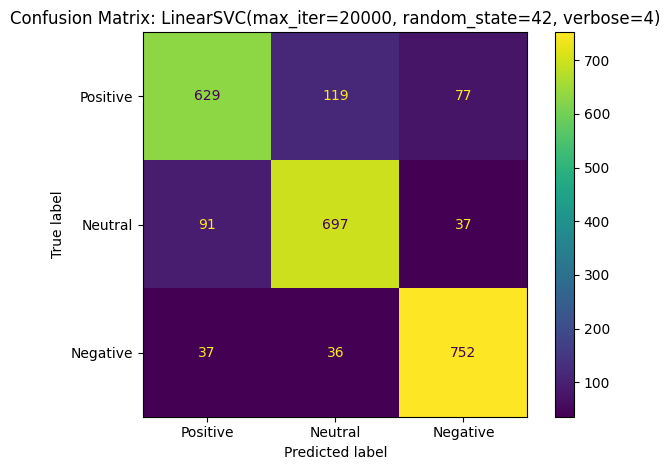

14:56:59 root INFO: 
Average: None
Precision:	[0.83091149 0.81807512 0.86836028]
Recall:		[0.76242424 0.84484848 0.91151515]
--> F1-score:	[0.79519595 0.83124627 0.88941455]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.83091149, 0.81807512, 0.86836028]),
 array([0.76242424, 0.84484848, 0.91151515]),
 array([0.79519595, 0.83124627, 0.88941455]))

In [ ]:
svc_clf = LinearSVC(loss="squared_hinge", multi_class="ovr", verbose=4, random_state=42, max_iter=20000, penalty='l2', dual=True)

svc_clf.fit(X_train, y_train_encode)

measure_score(svc_clf, X_train, y_train_encode, None, labels, 10, fig_title="Oversampling_LinearSVC_Default_3")

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

15:00:46 root INFO: Saving figure 'Oversampling_LinearSVC_Default_4' ...
		at Line 62 [save_fig() in utils.py, utils]
15:00:47 root INFO: Saved figure 'Oversampling_LinearSVC_Default_4'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\Oversampling_LinearSVC_Default_4.png
		at Line 66 [save_fig() in utils.py, utils]


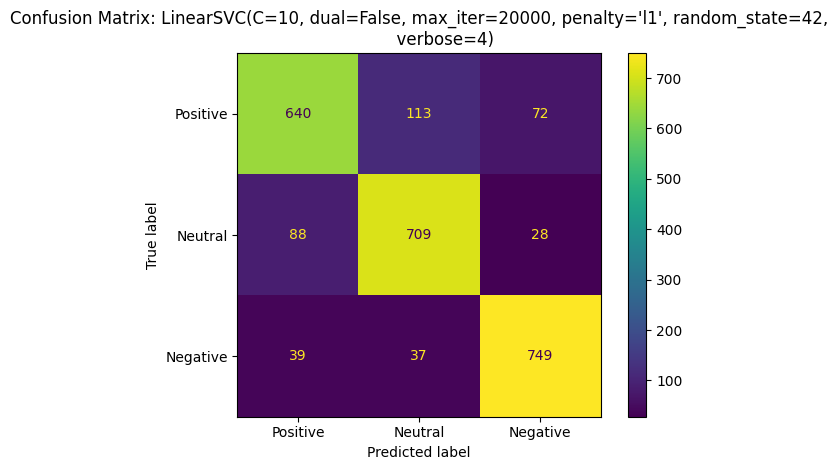

15:00:47 root INFO: 
Average: None
Precision:	[0.83441982 0.82537835 0.88221437]
Recall:		[0.77575758 0.85939394 0.90787879]
--> F1-score:	[0.8040201  0.84204276 0.8948626 ]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.83441982, 0.82537835, 0.88221437]),
 array([0.77575758, 0.85939394, 0.90787879]),
 array([0.8040201 , 0.84204276, 0.8948626 ]))

In [ ]:
svc_clf = LinearSVC(loss="squared_hinge", multi_class="ovr", verbose=4, random_state=42, max_iter=20000, penalty='l1', dual=False, C=10)

svc_clf.fit(X_train, y_train_encode)

measure_score(svc_clf, X_train, y_train_encode, None, labels, 10, fig_title="Oversampling_LinearSVC_Default_4")

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

15:02:52 root INFO: Saving figure 'Oversampling_LinearSVC_Default_4' ...
		at Line 62 [save_fig() in utils.py, utils]
15:02:52 root INFO: Saved figure 'Oversampling_LinearSVC_Default_4'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\Oversampling_LinearSVC_Default_4.png
		at Line 66 [save_fig() in utils.py, utils]


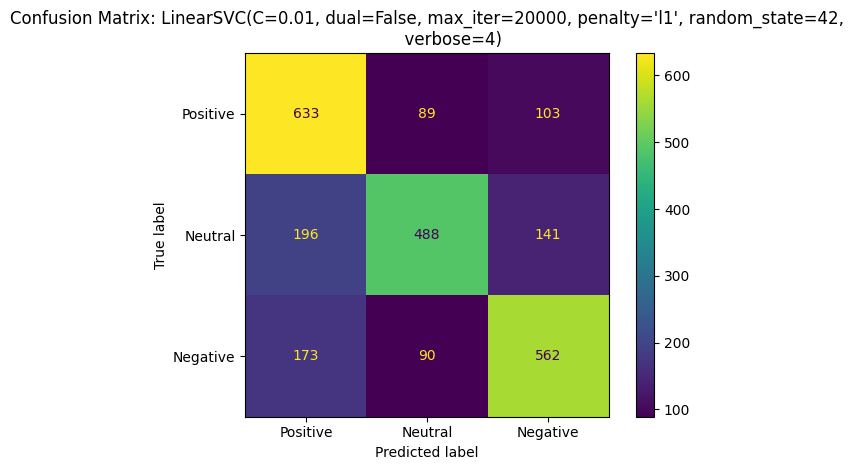

15:02:52 root INFO: 
Average: None
Precision:	[0.63173653 0.73163418 0.69727047]
Recall:		[0.76727273 0.59151515 0.68121212]
--> F1-score:	[0.69293924 0.6541555  0.68914776]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.63173653, 0.73163418, 0.69727047]),
 array([0.76727273, 0.59151515, 0.68121212]),
 array([0.69293924, 0.6541555 , 0.68914776]))

In [ ]:
svc_clf = LinearSVC(loss="squared_hinge", multi_class="ovr", verbose=4, random_state=42, max_iter=20000, penalty='l1', dual=False, C=1e-2)

svc_clf.fit(X_train, y_train_encode)

measure_score(svc_clf, X_train, y_train_encode, None, labels, 10, fig_title="Oversampling_LinearSVC_Default_4")

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

e:\Python\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
15:03:50 root INFO: Saving figure 'Oversampling_LinearSVC_Default_5' ...
		at Line 62 [save_fig() in utils.py, utils]
15:03:50 root INFO: Saved figure 'Oversampling_LinearSVC_Default_5'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\Oversampling_LinearSVC_Default_5.png
		at Line 66 [save_fig() in utils.py, utils]


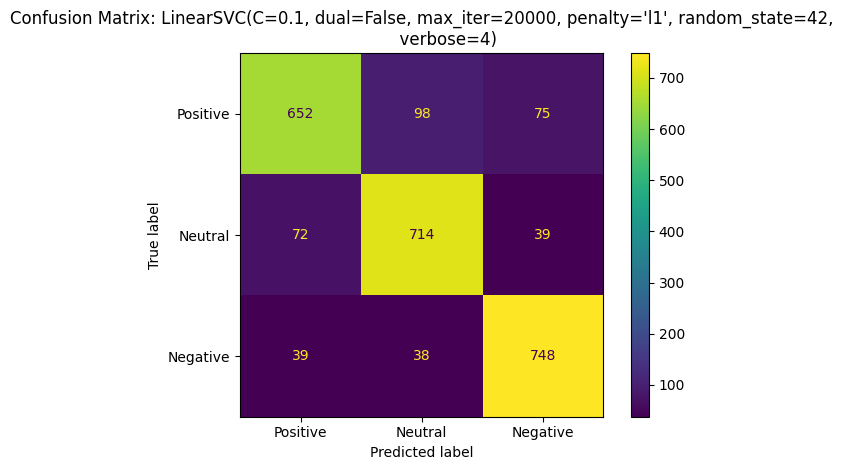

15:03:51 root INFO: 
Average: None
Precision:	[0.85452163 0.84       0.86774942]
Recall:		[0.79030303 0.86545455 0.90666667]
--> F1-score:	[0.82115869 0.85253731 0.88678127]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.85452163, 0.84      , 0.86774942]),
 array([0.79030303, 0.86545455, 0.90666667]),
 array([0.82115869, 0.85253731, 0.88678127]))

In [ ]:
svc_clf = LinearSVC(loss="squared_hinge", multi_class="ovr", verbose=4, random_state=42, max_iter=20000, penalty='l1', dual=False, C=1e-1)

svc_clf.fit(X_train, y_train_encode)

measure_score(svc_clf, X_train, y_train_encode, None, labels, 10, fig_title="Oversampling_LinearSVC_Default_5")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

16:12:45 root INFO: Saving figure 'Oversampling_LinearSVC_Gridsearch_BestParams' ...
		at Line 62 [save_fig() in utils.py, utils]
16:12:46 root INFO: Saved figure 'Oversampling_LinearSVC_Gridsearch_BestParams'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\Oversampling_LinearSVC_Gridsearch_BestParams.png
		at Line 66 [save_fig() in utils.py, utils]


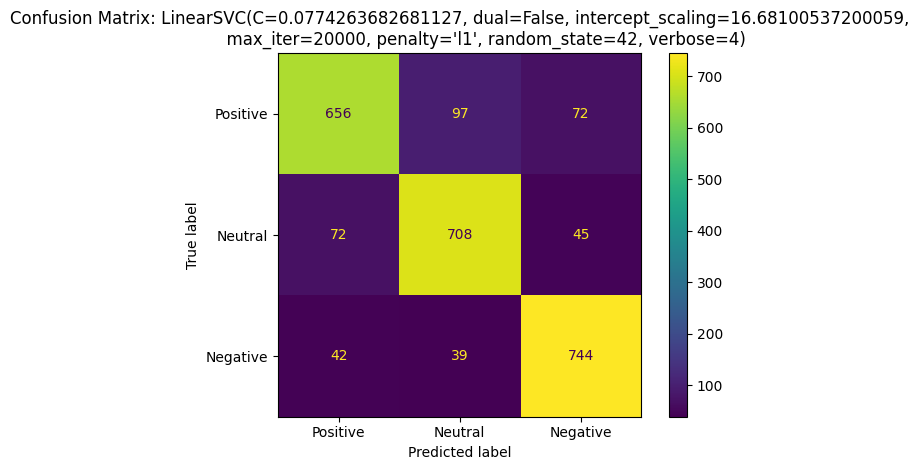

16:12:46 root INFO: 
Average: None
Precision:	[0.85194805 0.83886256 0.8641115 ]
Recall:		[0.79515152 0.85818182 0.90181818]
--> F1-score:	[0.82257053 0.84841222 0.88256228]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.85194805, 0.83886256, 0.8641115 ]),
 array([0.79515152, 0.85818182, 0.90181818]),
 array([0.82257053, 0.84841222, 0.88256228]))

In [ ]:
svc_grid_params = [
    {
        'C' : np.logspace(-2, 2, num=10),
        'fit_intercept' : [True, False],
        'intercept_scaling' : np.logspace(1, 3, num=10),
    }
]

svc_grid_search = GridSearchCV(
    estimator=LinearSVC(loss="squared_hinge", multi_class="ovr", verbose=4, random_state=42, max_iter=20000, penalty='l1', dual=False),
    param_grid=svc_grid_params,
    scoring='f1_micro',
    n_jobs=-1,
    cv=5,
    verbose=4,
    return_train_score=True,
)

svc_grid_search.fit(X_train, y_train_encode)

measure_score(svc_grid_search.best_estimator_, X_train, y_train_encode, None, labels, cv=10, save_figure=True, fig_title="Oversampling_LinearSVC_Gridsearch_BestParams")

In [ ]:
save_model("ovs_linearsvc.pkl", svc_grid_search.best_estimator_)

16:14:22 root INFO: Đang lưu lại mô hình...
		at Line 88 [save_model() in utils.py, utils]
16:14:22 root INFO: Lưu thành công!
		at Line 92 [save_model() in utils.py, utils]


Kiểm thử trên tập kiểm thử:

In [ ]:
X_test = test_set.drop(columns="label", axis=1).copy()
y_test = test_set["label"]
y_test_encode = y_test.apply(lambda x : {label : i for i, label in enumerate(labels)}.get(x))

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

16:16:58 root INFO: Saving figure 'Oversampling_LinearSVC_TestingSet' ...
		at Line 62 [save_fig() in utils.py, utils]


[LibLinear]

16:16:59 root INFO: Saved figure 'Oversampling_LinearSVC_TestingSet'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\Oversampling_LinearSVC_TestingSet.png
		at Line 66 [save_fig() in utils.py, utils]


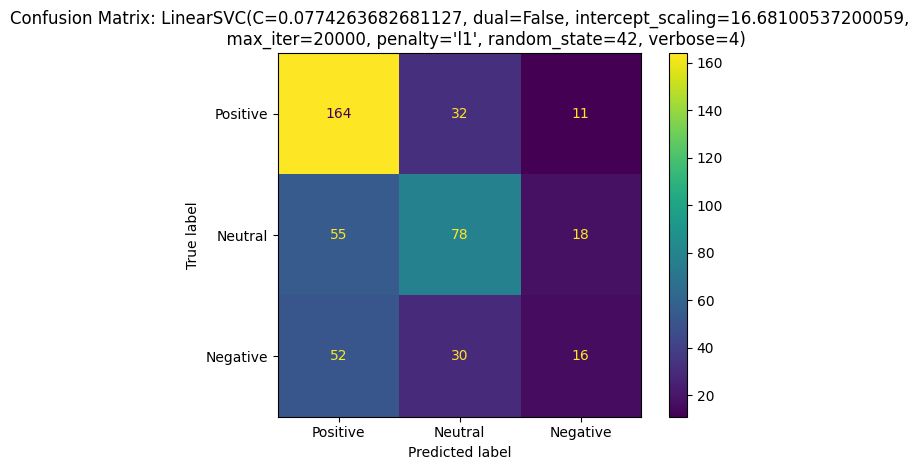

16:16:59 root INFO: 
Average: None
Precision:	[0.60516605 0.55714286 0.35555556]
Recall:		[0.79227053 0.51655629 0.16326531]
--> F1-score:	[0.68619247 0.53608247 0.22377622]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.60516605, 0.55714286, 0.35555556]),
 array([0.79227053, 0.51655629, 0.16326531]),
 array([0.68619247, 0.53608247, 0.22377622]))

In [ ]:
measure_score(svc_grid_search.best_estimator_, X_test, y_test_encode, None, labels, 10, fig_title="Oversampling_LinearSVC_TestingSet")

In [ ]:
from sklearn.metrics import classification_report

y_pred = svc_grid_search.best_estimator_.predict(X_test)

print(classification_report(y_test_encode, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.83      0.76       207
           1       0.71      0.54      0.62       151
           2       0.45      0.44      0.44        98

    accuracy                           0.65       456
   macro avg       0.62      0.60      0.61       456
weighted avg       0.65      0.65      0.64       456



In [ ]:
linear_svc : LinearSVC= load_model("linear_svc.pkl")
y_pred = linear_svc.predict(X_test)
print(classification_report(y_test_encode, y_pred))

5774
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       207
           1       0.92      0.87      0.89       151
           2       0.86      0.85      0.86        98

    accuracy                           0.90       456
   macro avg       0.90      0.89      0.89       456
weighted avg       0.90      0.90      0.90       456



### Huấn luyện mô hình SVC(Kernal="rbf") trên tập Oversampling:

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

16:29:24 root INFO: Saving figure 'Oversampling_SVCRBF_Default_1' ...
		at Line 62 [save_fig() in utils.py, utils]
16:29:25 root INFO: Saved figure 'Oversampling_SVCRBF_Default_1'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\Oversampling_SVCRBF_Default_1.png
		at Line 66 [save_fig() in utils.py, utils]


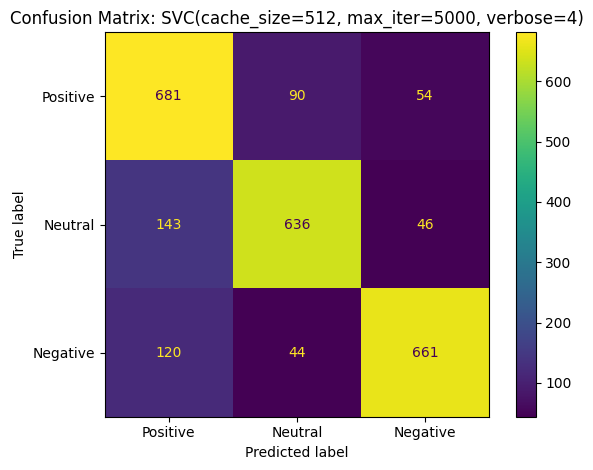

16:29:26 root INFO: 
Average: None
Precision:	[0.72139831 0.82597403 0.86859396]
Recall:		[0.82545455 0.77090909 0.80121212]
--> F1-score:	[0.76992651 0.79749216 0.83354351]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.72139831, 0.82597403, 0.86859396]),
 array([0.82545455, 0.77090909, 0.80121212]),
 array([0.76992651, 0.79749216, 0.83354351]))

In [ ]:
svc_clf = SVC(kernel="rbf", verbose=4, max_iter=5000, decision_function_shape="ovr",cache_size=512)

svc_clf.fit(X_train,y_train_encode)

measure_score(svc_clf, X_train, y_train_encode, None, labels, 10, fig_title="Oversampling_SVCRBF_Default_1")

In [ ]:
from sklearn.metrics import classification_report

y_pred = svc_clf.predict(X_test)

print(classification_report(y_test_encode, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.77      0.71       207
           1       0.69      0.56      0.62       151
           2       0.43      0.39      0.41        98

    accuracy                           0.62       456
   macro avg       0.59      0.57      0.58       456
weighted avg       0.62      0.62      0.61       456

